## LMQG Multiple Line Plot

<br>

### Development Envrionment

In [ ]:
%pip uninstall xlsxwriter

In [1]:
import os
import re
import glob
import datetime 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import openpyxl
from openpyxl import Workbook
from openpyxl.drawing.image import Image

In [2]:
pwd

'/'

In [3]:
cd workspace

/workspace


### Plot

In [2]:
def load_xlsx_file(path):

    model_name = []
    path = path
    xlsx_files = glob.glob(os.path.join(path, "*.xlsx"))   
    xlsx_files = sorted(xlsx_files, reverse=False)
    xlsx_files = sorted(xlsx_files, key=len)

    log_dfs = {}
    for xlsx_file in xlsx_files:
        xlsx_file_name = xlsx_file.split("\\")[1]
        log_df = pd.read_excel(xlsx_file, engine='openpyxl')
        log_dfs[xlsx_file_name] = log_df.round(4)
        
    print("Log Dataframe\n")

    for key, value in log_dfs.items():
        df_name = key.split(".")[0] + "_df"
        model_name.append(df_name)
        print(df_name)
        globals()[df_name] = value

    return model_name

In [3]:
def make_total_runtime(training_times):

    runtime_list= []

    for runtime in training_times:
        runtime = datetime.datetime.strptime(runtime, '%H:%M:%S')
        runtime = runtime.strftime('%H:%M:%S')
        runtime_list.append(runtime)
        
    runtime_dict = {'runtime': runtime_list}
    runtime_df = pd.DataFrame(data=runtime_dict)
    total_runtime = pd.to_timedelta(runtime_df["runtime"]).sum()    
    
    return total_runtime

In [4]:
def make_runtime_log_df():
    
    runtime_log_df = pd.DataFrame({'Model':[0], 'Training Time':[0], 'Evaluation Time':[0]})
    num = 0

    for variable in globals().keys():
        if 'flan_t5' in variable:
            log_df = globals()[variable]
            training_times = log_df['Training Time']
            total_training_time = make_total_runtime(training_times)

            evaluation_times = log_df['Evaluation Time'].dropna()
            total_evaluation_time = make_total_runtime(evaluation_times)
            
            num += 1
            runtime_log_df.loc[num] = [variable, total_training_time, total_evaluation_time]
            
    runtime_log_df = runtime_log_df.drop([0], axis = 0)
    runtime_log_df['Training Time'] = runtime_log_df['Training Time'].astype(str).str.split(' ').str[-1]
    runtime_log_df['Evaluation Time'] = runtime_log_df['Evaluation Time'].astype(str).str.split(' ').str[-1]
    runtime_log_df['Training Seconds'] = pd.to_timedelta(runtime_log_df['Training Time'].astype(str)).dt.total_seconds()
    runtime_log_df['Evaluation Seconds'] = pd.to_timedelta(runtime_log_df['Evaluation Time'].astype(str)).dt.total_seconds()
    runtime_log_df = runtime_log_df.astype({'Training Seconds': 'int'})
    runtime_log_df = runtime_log_df.astype({'Evaluation Seconds': 'int'})
    
    runtime_log_df['Model'] = runtime_log_df['Model'].str.replace('flan_t5_small_squad_qg_', '').str.replace('df', '').str.replace('_', ' ')
    
    for idx, value in enumerate(runtime_log_df['Model']):
        
        if value == '':
            runtime_log_df.loc[idx+1, 'Model'] = "base"

    runtime_log_df = runtime_log_df.sort_values('Model')
            
    return runtime_log_df

In [19]:
def make_log_plot_df(path):
    
    log_plot_df = pd.DataFrame({'""':[""]})
    log_path = path + "log_plot.xlsx"
    log_plot_df.to_excel(log_path, index=False)

    log_plot_pngs = sorted(glob.glob(os.path.join(path, "*.png"))) 

    row_num = -19
    workbook = openpyxl.load_workbook(log_path)
    worksheet = workbook.active
    for idx, log_plot_png in enumerate(log_plot_pngs):
        
        img = Image(log_plot_png) 
        
        if 'runtime' in log_plot_png and idx % 2 == 0:
            row_num += 20
            worksheet.add_image(img, 'A' + str(row_num))
            
        elif 'runtime' in log_plot_png and idx % 2 == 1:
            worksheet.add_image(img, 'R' + str(row_num))
            
        elif 'loss' in log_plot_png:
            row_num += 28
            worksheet.add_image(img, 'A' + str(row_num))            
                
        elif 'runtime' not in log_plot_png and idx >= 3 and idx % 2 == 1:
            if idx == 3:
                row_num += 22
            if idx > 3:
                row_num += 39
                            
            worksheet.add_image(img, 'A' + str(row_num))
            
        elif 'runtime' not in log_plot_png and idx >= 3 and idx % 2 == 0:
            worksheet.add_image(img, 'R' + str(row_num))
        
    workbook.save(log_path)

In [6]:
path = "log"
model_name = load_xlsx_file(path)

Log Dataframe

flan_t5_small_squad_qg_df
flan_t5_small_squad_qg_lora_r8_al16_df
flan_t5_small_squad_qg_lora_r16_al16_df
flan_t5_small_squad_qg_lora_r32_al16_df
flan_t5_small_squad_qg_lora_r64_al16_df
flan_t5_small_squad_qg_lora_r128_al16_df


In [7]:
runtime_log_df = make_runtime_log_df()
runtime_log_df

,Model,Training Time,Evaluation Time,Training Seconds,Evaluation Seconds
1,base,02:24:28,01:06:47,8668,4007
6,lora r128 al16,02:07:21,01:13:55,7641,4435
3,lora r16 al16,02:07:10,01:19:05,7630,4745
4,lora r32 al16,02:07:23,01:13:38,7643,4418
5,lora r64 al16,02:07:26,01:13:43,7646,4423
2,lora r8 al16,02:06:57,01:14:32,7617,4472


In [20]:
path = "plot/flan_t5_small_lora_r_al16/"
make_log_plot_df(path)

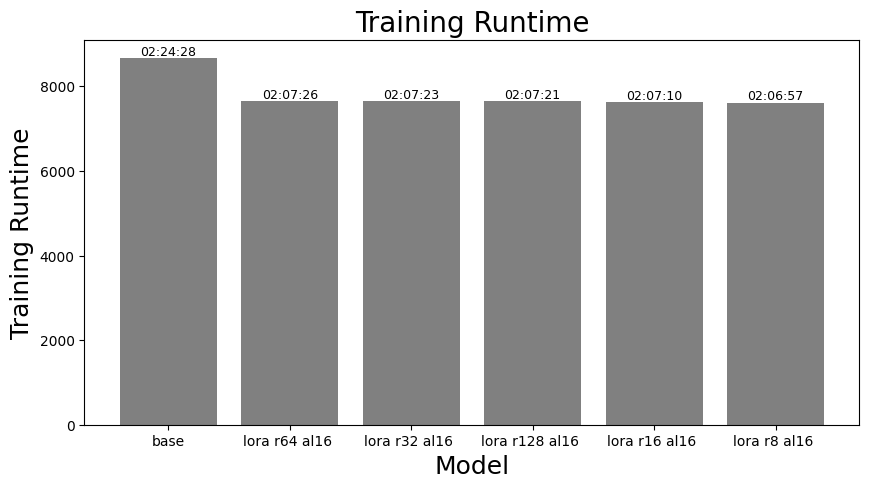

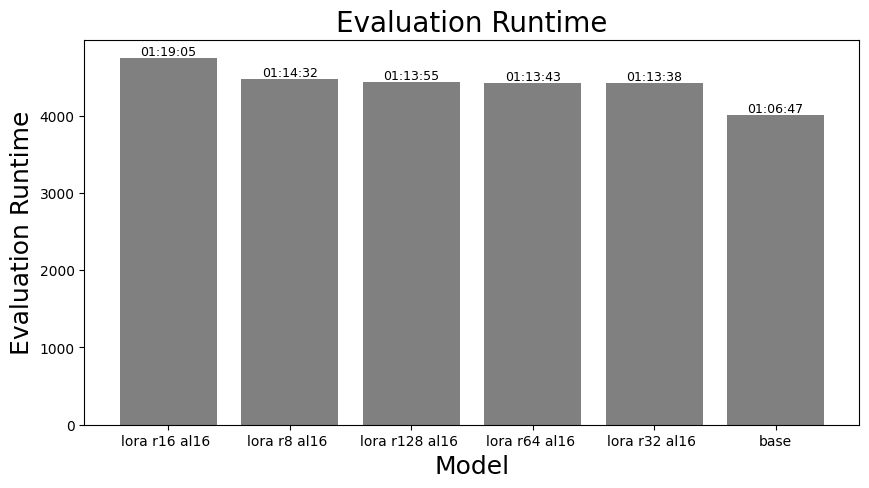

In [9]:
model_name = list(runtime_log_df['Model'])
training_seconds = list(runtime_log_df['Training Seconds'])
training_times = list(runtime_log_df['Training Time'])

traning_runtime_df = pd.DataFrame({"Model": model_name,
                  "Training Runtime": training_seconds})
traning_runtime_df_sorted = traning_runtime_df.sort_values('Training Runtime',ascending=False)

plt.figure(figsize=(10, 5))                                                  
bar_width = 0.1                                                                

plt.bar('Model', 'Training Runtime',data=traning_runtime_df_sorted, color = 'grey')       


for i, v in enumerate(model_name):
    plt.text(v, training_seconds[i],training_times[i],      
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')    


plt.title('Training Runtime', fontsize=20)     
plt.xlabel('Model', fontsize=18)     
plt.ylabel('Training Runtime', fontsize=18)  
plt.savefig('plot/flan_t5_small_lora_r_al16/0_training_runtime.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()        

model_name = list(runtime_log_df['Model'])
evaluation_seconds = list(runtime_log_df['Evaluation Seconds'])
evaluation_times = list(runtime_log_df['Evaluation Time'])

traning_runtime_df = pd.DataFrame({"Model": model_name,
                  "Evaluation Runtime": evaluation_seconds})
traning_runtime_df_sorted = traning_runtime_df.sort_values('Evaluation Runtime',ascending=False)

plt.figure(figsize=(10, 5))                                                  
bar_width = 0.1                                                                

plt.bar('Model', 'Evaluation Runtime',data=traning_runtime_df_sorted, color = 'grey')       


for i, v in enumerate(model_name):
    plt.text(v, evaluation_seconds[i],evaluation_times[i],      
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')    


plt.title('Evaluation Runtime', fontsize=20)     
plt.xlabel('Model', fontsize=18)     
plt.ylabel('Evaluation Runtime', fontsize=18) 
plt.savefig('plot/flan_t5_small_lora_r_al16/1_evaluation_runtime.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight') 
plt.show()   

In [14]:
path = "plot/flan_t5_small_lora_r_al16/"
make_log_plot_df(path)

In [10]:
print(model_name)

['base', 'lora r128 al16 ', 'lora r16 al16 ', 'lora r32 al16 ', 'lora r64 al16 ', 'lora r8 al16 ']


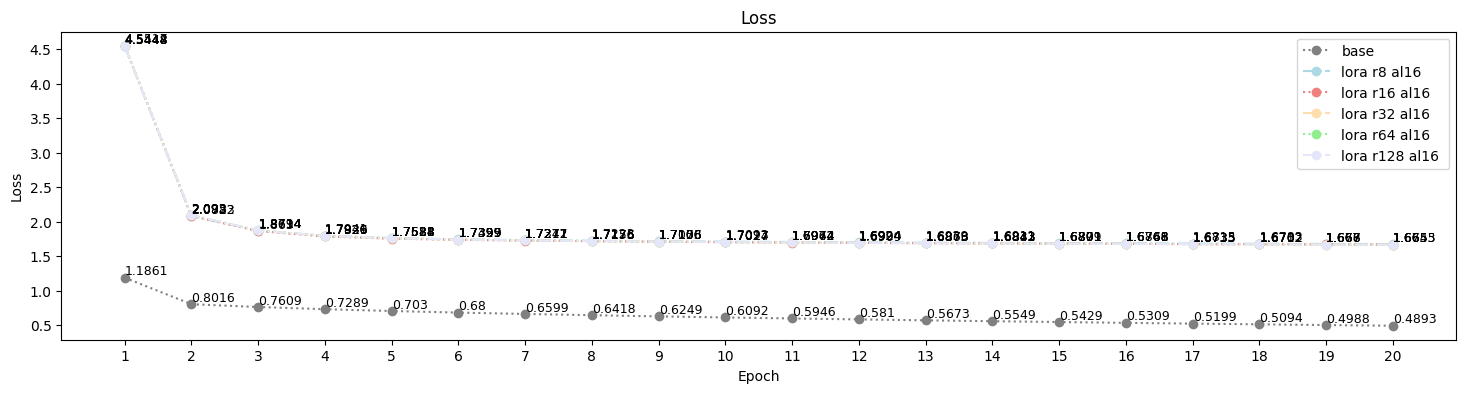

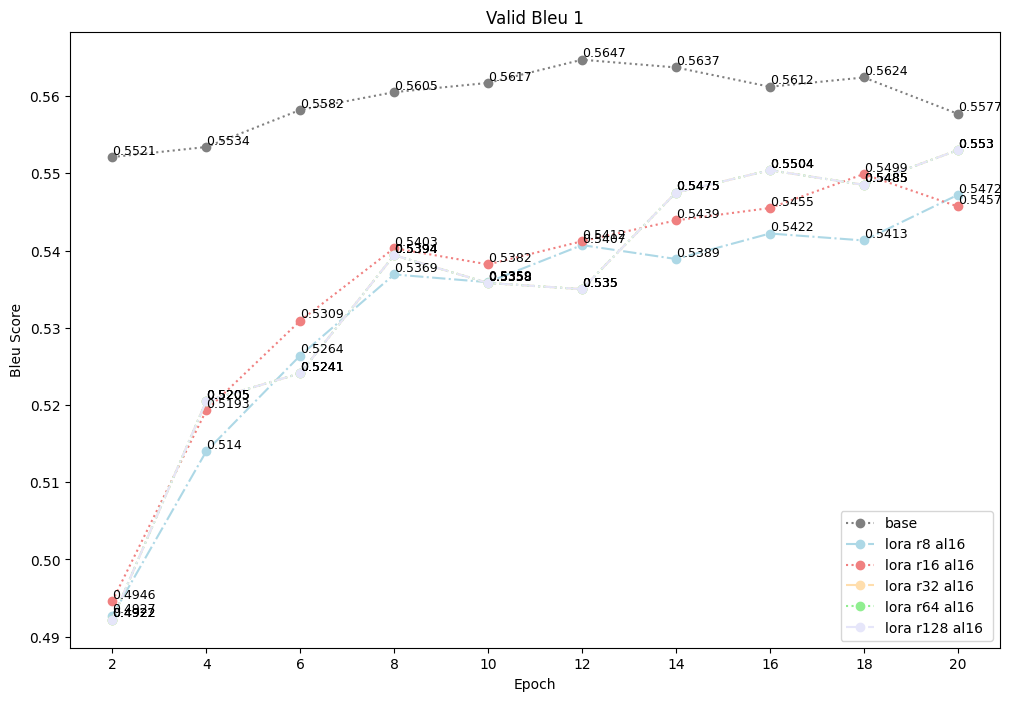

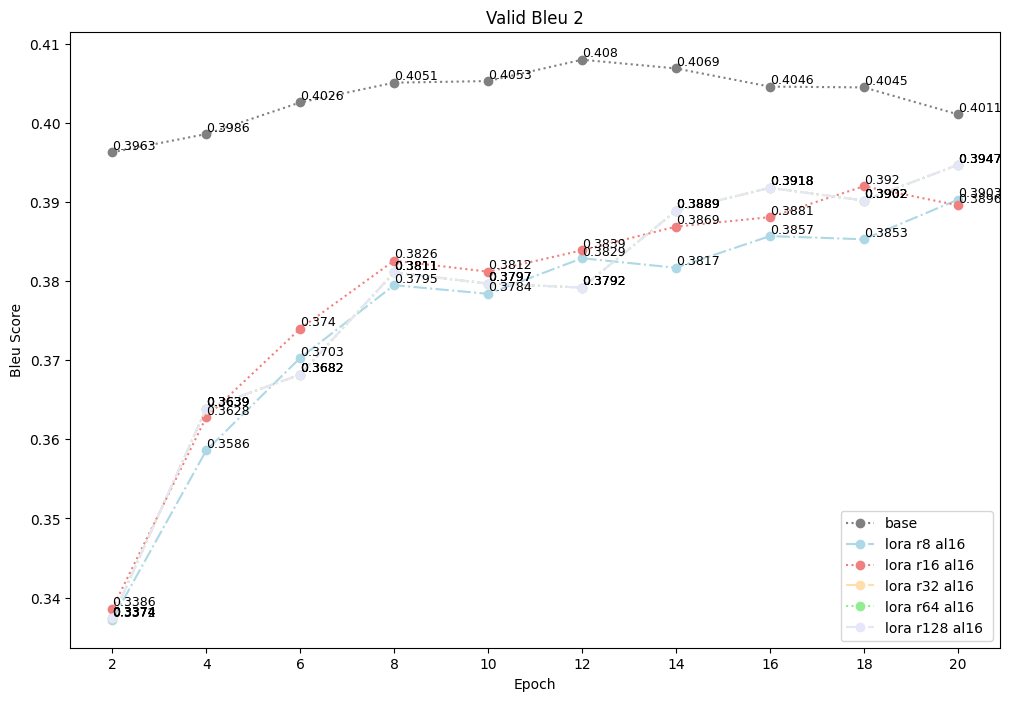

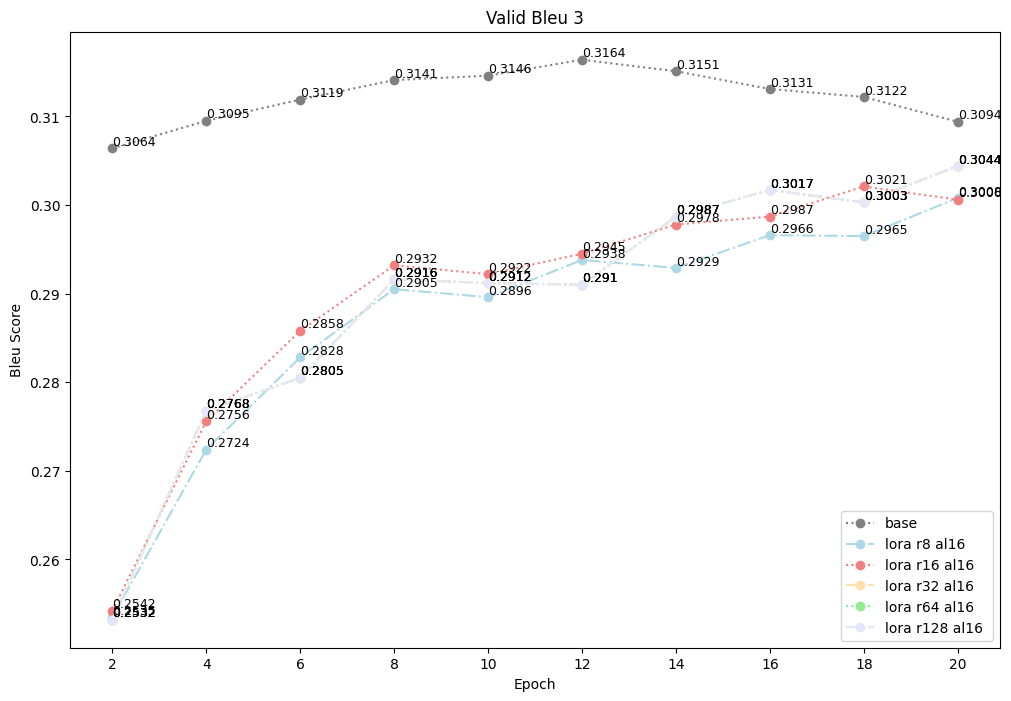

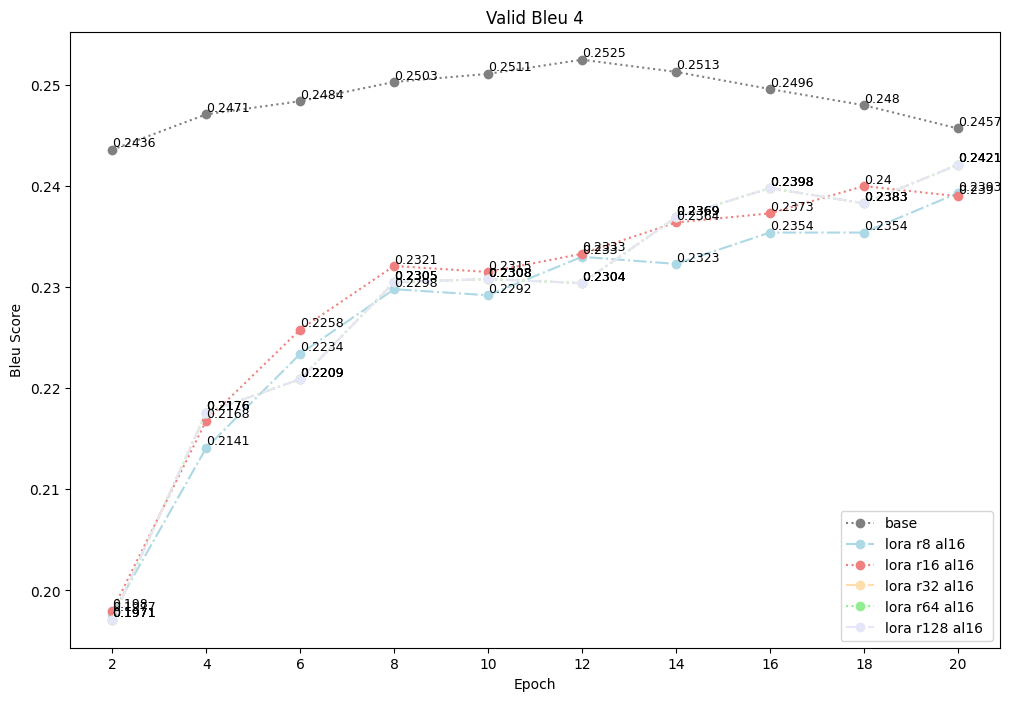

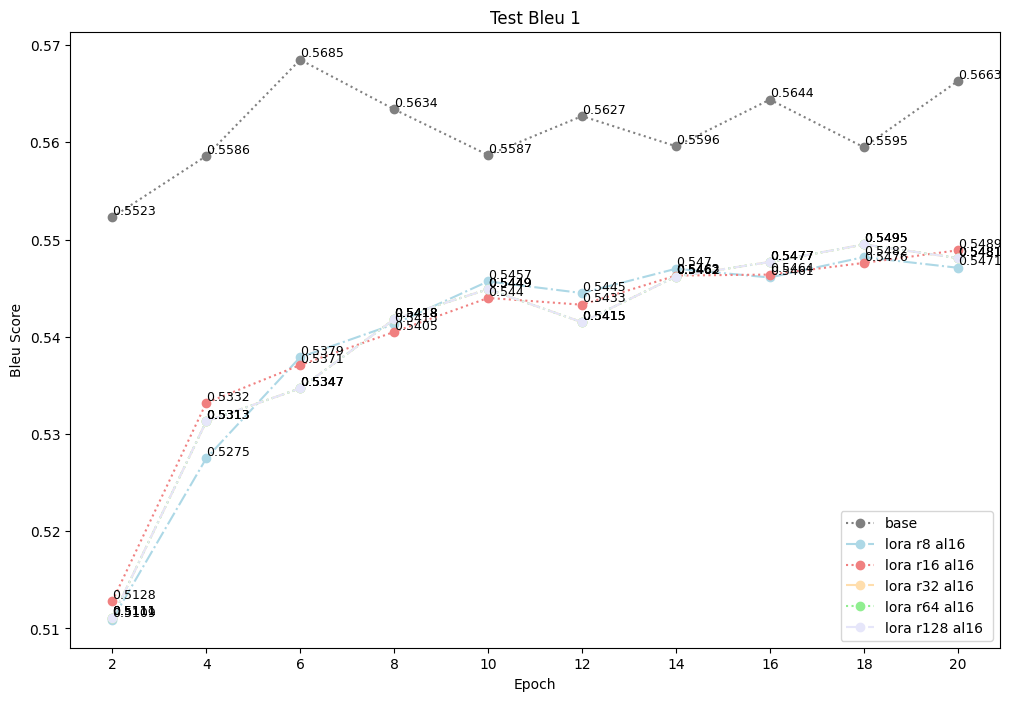

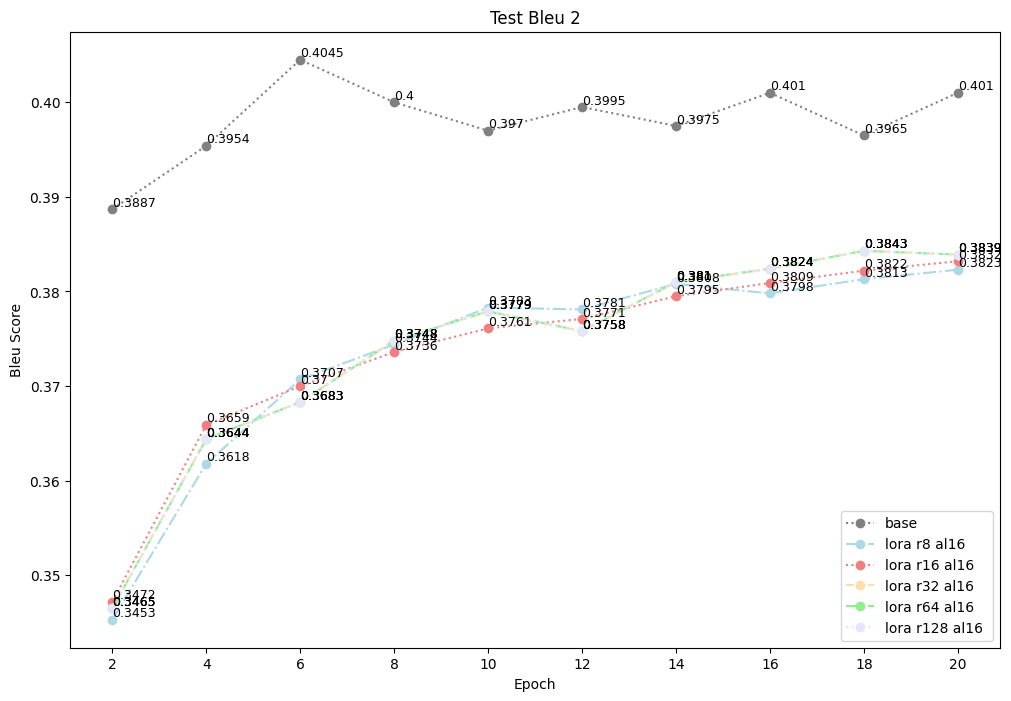

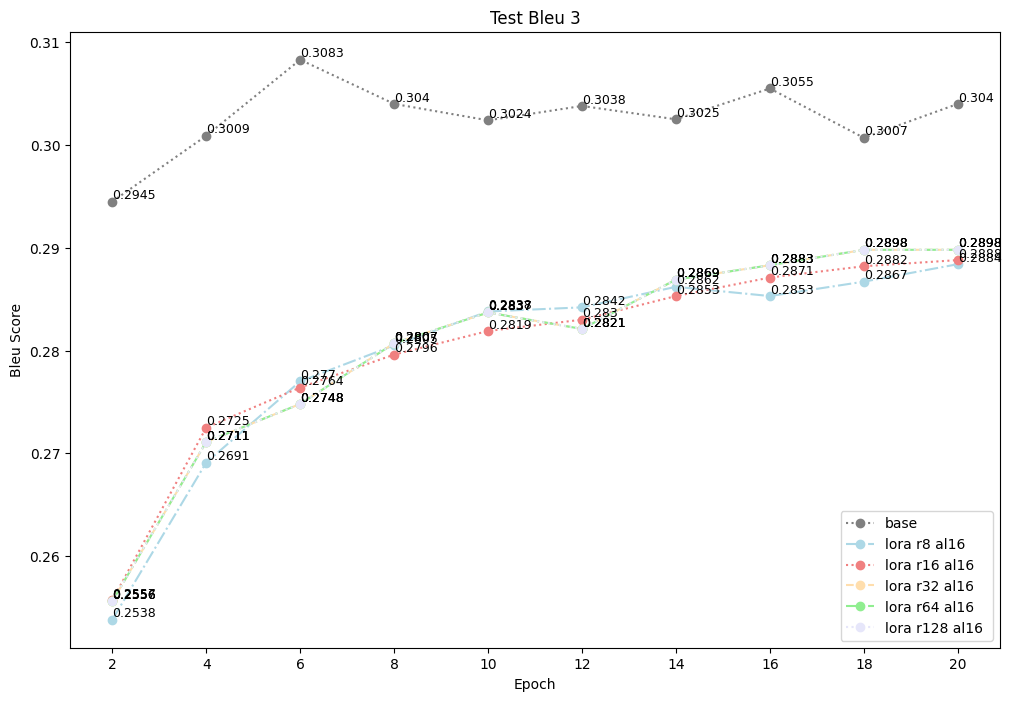

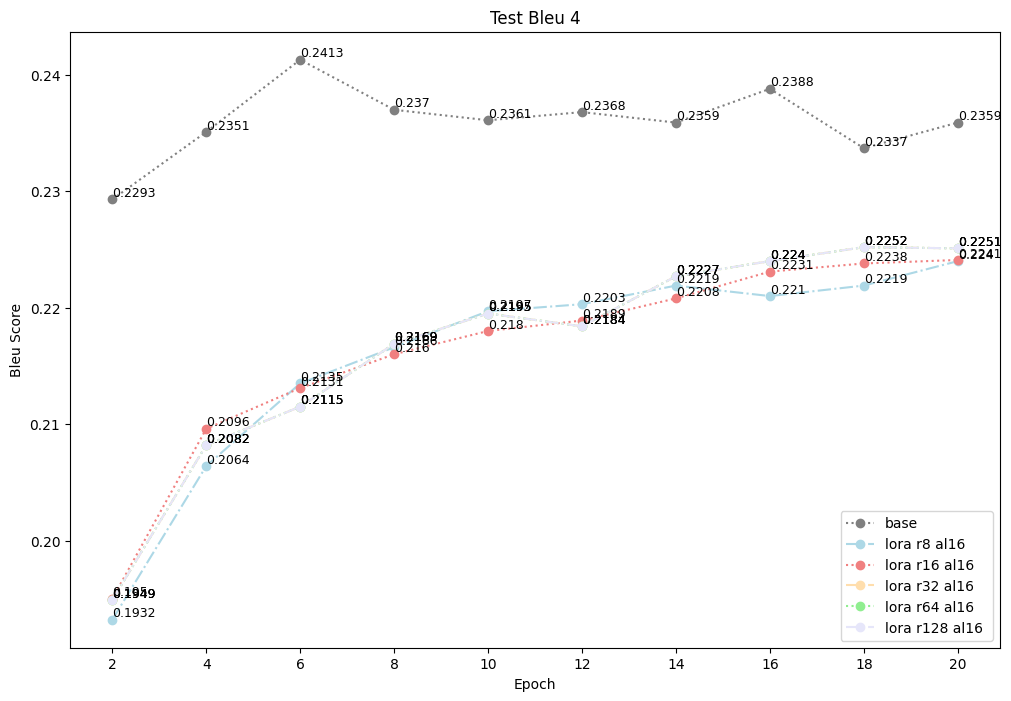

In [12]:
loss_epoch = flan_t5_small_squad_qg_df['Epoch']
bleu_epoch = flan_t5_small_squad_qg_df[flan_t5_small_squad_qg_df['Epoch'] % 2 == 0].reset_index()['Epoch']

loss_0 = flan_t5_small_squad_qg_df['Loss']
valid_bleu_01 = flan_t5_small_squad_qg_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_02 = flan_t5_small_squad_qg_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_03 = flan_t5_small_squad_qg_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_04 = flan_t5_small_squad_qg_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_01 = flan_t5_small_squad_qg_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_02 = flan_t5_small_squad_qg_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_03 = flan_t5_small_squad_qg_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_04 = flan_t5_small_squad_qg_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

loss_1 = flan_t5_small_squad_qg_lora_r8_al16_df['Loss']
valid_bleu_11 = flan_t5_small_squad_qg_lora_r8_al16_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_12 = flan_t5_small_squad_qg_lora_r8_al16_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_13 = flan_t5_small_squad_qg_lora_r8_al16_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_14 = flan_t5_small_squad_qg_lora_r8_al16_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_11 = flan_t5_small_squad_qg_lora_r8_al16_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_12 = flan_t5_small_squad_qg_lora_r8_al16_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_13 = flan_t5_small_squad_qg_lora_r8_al16_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_14 = flan_t5_small_squad_qg_lora_r8_al16_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

loss_2 = flan_t5_small_squad_qg_lora_r16_al16_df['Loss']
valid_bleu_21 = flan_t5_small_squad_qg_lora_r16_al16_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_22 = flan_t5_small_squad_qg_lora_r16_al16_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_23 = flan_t5_small_squad_qg_lora_r16_al16_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_24 = flan_t5_small_squad_qg_lora_r16_al16_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_21 = flan_t5_small_squad_qg_lora_r16_al16_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_22 = flan_t5_small_squad_qg_lora_r16_al16_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_23 = flan_t5_small_squad_qg_lora_r16_al16_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_24 = flan_t5_small_squad_qg_lora_r16_al16_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

loss_3 = flan_t5_small_squad_qg_lora_r32_al16_df['Loss']
valid_bleu_31 = flan_t5_small_squad_qg_lora_r32_al16_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_32 = flan_t5_small_squad_qg_lora_r32_al16_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_33 = flan_t5_small_squad_qg_lora_r32_al16_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_34 = flan_t5_small_squad_qg_lora_r32_al16_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_31 = flan_t5_small_squad_qg_lora_r32_al16_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_32 = flan_t5_small_squad_qg_lora_r32_al16_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_33 = flan_t5_small_squad_qg_lora_r32_al16_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_34 = flan_t5_small_squad_qg_lora_r32_al16_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

loss_4 = flan_t5_small_squad_qg_lora_r64_al16_df['Loss']
valid_bleu_41 = flan_t5_small_squad_qg_lora_r64_al16_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_42 = flan_t5_small_squad_qg_lora_r64_al16_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_43 = flan_t5_small_squad_qg_lora_r64_al16_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_44 = flan_t5_small_squad_qg_lora_r64_al16_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_41 = flan_t5_small_squad_qg_lora_r64_al16_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_42 = flan_t5_small_squad_qg_lora_r64_al16_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_43 = flan_t5_small_squad_qg_lora_r64_al16_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_44 = flan_t5_small_squad_qg_lora_r64_al16_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

loss_5 = flan_t5_small_squad_qg_lora_r128_al16_df['Loss']
valid_bleu_51 = flan_t5_small_squad_qg_lora_r128_al16_df['Valid Bleu 1'].dropna().reset_index()['Valid Bleu 1']
valid_bleu_52 = flan_t5_small_squad_qg_lora_r128_al16_df['Valid Bleu 2'].dropna().reset_index()['Valid Bleu 2']
valid_bleu_53 = flan_t5_small_squad_qg_lora_r128_al16_df['Valid Bleu 3'].dropna().reset_index()['Valid Bleu 3']
valid_bleu_54 = flan_t5_small_squad_qg_lora_r128_al16_df['Valid Bleu 4'].dropna().reset_index()['Valid Bleu 4']
test_bleu_51 = flan_t5_small_squad_qg_lora_r128_al16_df['Test Bleu 1'].dropna().reset_index()['Test Bleu 1']
test_bleu_52 = flan_t5_small_squad_qg_lora_r128_al16_df['Test Bleu 2'].dropna().reset_index()['Test Bleu 2']
test_bleu_53 = flan_t5_small_squad_qg_lora_r128_al16_df['Test Bleu 3'].dropna().reset_index()['Test Bleu 3']
test_bleu_54 = flan_t5_small_squad_qg_lora_r128_al16_df['Test Bleu 4'].dropna().reset_index()['Test Bleu 4']

linestyle_list = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
linecolor_list = ['grey', 'lightblue', 'lightcoral', 'navajowhite', 'lightgreen', 'lavender']
# https://matplotlib.org/stable/gallery/color/named_colors.html

def make_plot_text(epoch, value):
    for i, v in enumerate(epoch):
        plt.text(v, value[i], value[i], 
                fontsize = 9, color='black', ha="left",
                horizontalalignment='center', verticalalignment='bottom')  
    
plt.figure(figsize=(18, 4))
plt.plot(loss_epoch, loss_0, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3]) 
plt.plot(loss_epoch, loss_1, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(loss_epoch, loss_2, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(loss_epoch, loss_3, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(loss_epoch, loss_4, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(loss_epoch, loss_5, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Loss') 
plt.xticks(list(range(1,max(loss_epoch)+1)),[str(i) for i in range(1,max(loss_epoch)+1)])

make_plot_text(loss_epoch, loss_0); make_plot_text(loss_epoch, loss_1)
make_plot_text(loss_epoch, loss_2); make_plot_text(loss_epoch, loss_3)
make_plot_text(loss_epoch, loss_4); make_plot_text(loss_epoch, loss_5)

plt.title('Loss')
plt.legend() 
plt.savefig('plot/flan_t5_small_lora_r_al16/loss.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, valid_bleu_01, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, valid_bleu_11, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, valid_bleu_21, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_31, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, valid_bleu_41, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_51, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, valid_bleu_01); make_plot_text(bleu_epoch, valid_bleu_11)
make_plot_text(bleu_epoch, valid_bleu_21); make_plot_text(bleu_epoch, valid_bleu_31)
make_plot_text(bleu_epoch, valid_bleu_41); make_plot_text(bleu_epoch, valid_bleu_51)

plt.title('Valid Bleu 1')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/valid_bleu_1.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, valid_bleu_02, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, valid_bleu_12, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, valid_bleu_22, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_32, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, valid_bleu_42, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_52, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, valid_bleu_02); make_plot_text(bleu_epoch, valid_bleu_12)
make_plot_text(bleu_epoch, valid_bleu_22); make_plot_text(bleu_epoch, valid_bleu_32)
make_plot_text(bleu_epoch, valid_bleu_42); make_plot_text(bleu_epoch, valid_bleu_52)

plt.title('Valid Bleu 2')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/valid_bleu_2.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, valid_bleu_03, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, valid_bleu_13, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, valid_bleu_23, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_33, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, valid_bleu_43, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_53, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, valid_bleu_03); make_plot_text(bleu_epoch, valid_bleu_13)
make_plot_text(bleu_epoch, valid_bleu_23); make_plot_text(bleu_epoch, valid_bleu_33)
make_plot_text(bleu_epoch, valid_bleu_43); make_plot_text(bleu_epoch, valid_bleu_53)

plt.title('Valid Bleu 3')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/valid_bleu_3.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, valid_bleu_04, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, valid_bleu_14, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, valid_bleu_24, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_34, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, valid_bleu_44, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, valid_bleu_54, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, valid_bleu_04); make_plot_text(bleu_epoch, valid_bleu_14)
make_plot_text(bleu_epoch, valid_bleu_24); make_plot_text(bleu_epoch, valid_bleu_34)
make_plot_text(bleu_epoch, valid_bleu_44); make_plot_text(bleu_epoch, valid_bleu_54)

plt.title('Valid Bleu 4')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/valid_bleu_4.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, test_bleu_01, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, test_bleu_11, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, test_bleu_21, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, test_bleu_31, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, test_bleu_41, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3])
plt.plot(bleu_epoch, test_bleu_51, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, test_bleu_01); make_plot_text(bleu_epoch, test_bleu_11)
make_plot_text(bleu_epoch, test_bleu_21); make_plot_text(bleu_epoch, test_bleu_31)
make_plot_text(bleu_epoch, test_bleu_41); make_plot_text(bleu_epoch, test_bleu_51)

plt.title('Test Bleu 1')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/test_bleu_1.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, test_bleu_02, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, test_bleu_12, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, test_bleu_22, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, test_bleu_32, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[5]) 
plt.plot(bleu_epoch, test_bleu_42, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[6]) 
plt.plot(bleu_epoch, test_bleu_52, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[7]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, test_bleu_02); make_plot_text(bleu_epoch, test_bleu_12)
make_plot_text(bleu_epoch, test_bleu_22); make_plot_text(bleu_epoch, test_bleu_32)
make_plot_text(bleu_epoch, test_bleu_42); make_plot_text(bleu_epoch, test_bleu_52)

plt.title('Test Bleu 2')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/test_bleu_2.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, test_bleu_03, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, test_bleu_13, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, test_bleu_23, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, test_bleu_33, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[5]) 
plt.plot(bleu_epoch, test_bleu_43, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[6]) 
plt.plot(bleu_epoch, test_bleu_53, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[7]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, test_bleu_03); make_plot_text(bleu_epoch, test_bleu_13)
make_plot_text(bleu_epoch, test_bleu_23); make_plot_text(bleu_epoch, test_bleu_33)
make_plot_text(bleu_epoch, test_bleu_43); make_plot_text(bleu_epoch, test_bleu_53)

plt.title('Test Bleu 3')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/test_bleu_3.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(bleu_epoch, test_bleu_04, marker='o', color=linecolor_list[0], label=model_name[0], linestyle=linestyle_list[3])  
plt.plot(bleu_epoch, test_bleu_14, marker='o', color=linecolor_list[1], label=model_name[5], linestyle=linestyle_list[2])  
plt.plot(bleu_epoch, test_bleu_24, marker='o', color=linecolor_list[2], label=model_name[2], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, test_bleu_34, marker='o', color=linecolor_list[3], label=model_name[3], linestyle=linestyle_list[2]) 
plt.plot(bleu_epoch, test_bleu_44, marker='o', color=linecolor_list[4], label=model_name[4], linestyle=linestyle_list[3]) 
plt.plot(bleu_epoch, test_bleu_54, marker='o', color=linecolor_list[5], label=model_name[1], linestyle=linestyle_list[2]) 
plt.xlabel('Epoch'); plt.ylabel('Bleu Score') 
plt.xticks(list(range(2,max(bleu_epoch)+1, 2)),[str(i) for i in range(1,max(bleu_epoch)+1) if i % 2 == 0])

make_plot_text(bleu_epoch, test_bleu_04); make_plot_text(bleu_epoch, test_bleu_14)
make_plot_text(bleu_epoch, test_bleu_24); make_plot_text(bleu_epoch, test_bleu_34)
make_plot_text(bleu_epoch, test_bleu_44); make_plot_text(bleu_epoch, test_bleu_54)

plt.title('Test Bleu 4')
plt.legend()
plt.savefig('plot/flan_t5_small_lora_r_al16/test_bleu_4.png', facecolor='#eeeeee', edgecolor='black', format='png', bbox_inches='tight')
plt.show()